In [46]:
import tensorflow as tf
import numpy as np
import pathlib
import datetime

# printout versions
print(f"Tensor Flow Version: {tf.__version__}")
print(f"numpy Version: {np.version.version}")

Tensor Flow Version: 2.5.0
numpy Version: 1.21.2


In [47]:
import matplotlib.pyplot as plt
from tensorflow.python.keras.layers import InputLayer, Input
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.python.keras import backend as K
import math

# Code to generate embeddings:

In [48]:
def apply_all_shifts(im, shift_step):
    '''
    arg(s): 
        im, an image of shape (im_size, im_size, 3)
    return: 
        im_all_shifts, a list of all shifted images from the input image
        n_shifts, number of shifted images
    '''
    
    ## vertical size might not be the same as the horizontal
    im_size_vertical = im.shape[0]
    im_size_horizontal = im.shape[1]
    
    n_shifts_vertical = int(math.ceil(im_size_vertical/ shift_step))
    n_shifts_horizontal = int(math.ceil(im_size_horizontal/ shift_step))
    
    im_all_shifts = []
    im_shift = im
    for i in range(n_shifts_vertical):
        im_shift = np.roll(im_shift, shift = shift_step * i, axis=0)
        
        for j in range(n_shifts_horizontal):
            im_shift = np.roll(im_shift, shift = shift_step * j, axis=1)
            im_all_shifts.append(im_shift)
            
    im_all_shifts =  np.array(im_all_shifts)
    return im_all_shifts, n_shifts_vertical * n_shifts_horizontal

In [49]:
 def compute_neuron_output_alt(layer_indices, images, plot_activity = False):

    '''
    arg(s):
        layer_indices: list of the indices of the layers we want to take neuron outputs from
        images: an array of images (stimuli)
    return:
        
    '''
    n_layers = len(layer_indices)
    neuron_output_highest = []
    all_fm_avg = []
    neuron_labels = []
    
    for layer_index in layer_indices:
        layer = model.layers[layer_index] 
        
        # check for convolutional layer
        if 'conv' not in layer.name:
            continue
        
        ## note: always take the images as inputs
        output_layer = K.function(inputs=[model.layers[1].input], 
                              outputs=[layer.output])
        
        ## output is n feature maps
        neuron_output = output_layer(images)[0]
   
        ## number of neurons is nrow * ncol * n_feature_maps
        n_images, n_row, n_col, n_feature_maps = neuron_output.shape[:]
        n_neurons = n_row * n_col
        
#         ## remove the neurons at the edges
#         neuron_removed_index = neuron_index[:,2:(n_row-2),2:(n_col-2),:]
#         n_images, n_row, n_col, n_feature_maps = neuron_output.shape[:]
#         n_neurons = n_row * n_col
        
        neuron_index = np.empty((n_row,n_col),dtype=int)
        index = 0
        for i in range(n_row):
            for j in range(n_col):
                neuron_index[i, j] = index
                index += 1
                
        ## obtain the index of the neurons at the edges
        neuron_edge_index = np.hstack((neuron_index[[0,1,n_row-2,n_row-1],:].reshape((4*32,1)), neuron_index[:,[0,1,n_col-2,n_col-1]].reshape((4*32,1))))
        neuron_edge_index = neuron_edge_index.reshape((256,1))
        

        ## re-label the neurons at the edge with a different color
        neuron_labels = []
        for i in range(10):    
            neuron_labels = np.hstack((neuron_labels, [i] * n_neurons))
            neuron_labels = np.array(neuron_labels)
            neuron_labels[n_neurons * i + neuron_edge_index-1] = 15
        
        neuron_output = neuron_output.reshape((n_images, n_neurons, n_feature_maps))
        
        ## transpose to organize by feature maps
        ## neuron_output_by_fm is (n_images, n_feature_maps, #neurons)
        neuron_output_by_fm = np.transpose(neuron_output, (0, 2, 1)) 
        
        ## compute avg neuron firing rate in each feature map
        ## fm_avg is (n_images, n_feature_maps)
        fm_avg = neuron_output_by_fm.sum(axis=2) / neuron_output_by_fm.shape[2]
        
        if layer_index == 1:
            fm_avg_all_layers = fm_avg
            neuron_output_by_fm_all_layers = neuron_output_by_fm
        else:
            fm_avg_all_layers = np.hstack((fm_avg_all_layers, fm_avg))
            neuron_output_by_fm_all_layers = np.concatenate((neuron_output_by_fm_all_layers,neuron_output_by_fm), axis = 1)

    neuron_output_highest = np.empty((n_images,n_neurons *10))
    for i in range(n_images):
        max10_indices = np.argpartition(fm_avg_all_layers[i], -10, axis = 0)[-10:]
        neuron_output_highest[i] = neuron_output_by_fm_all_layers[i, max10_indices, :].reshape((1,n_neurons *10))

        
    neuron_labels = np.array(neuron_labels)     
    return neuron_output_highest, fm_avg_all_layers, neuron_labels 

In [50]:
def show_stimuli(layer_indices, n_images_per_class, image_classes, shifts, plot_activity = False):
    '''
    arg(s): 
        layer_indices
        n_images_per_class
        image_classes
        shifts = True/False
    return:
        neuron_output_shifts_avg, (n_images, n_neurons)
    '''
    # select images from specified classes:
    
    n_classes = len(image_classes)
    n_images = n_classes * n_images_per_class
    
    for i in range(n_classes):
        idx = (y_train == image_classes[i]).reshape(x_train.shape[0])
        images = x_train[idx]
        ## images has shape (5000, 32, 32, 3), take the first n_images_per_class images from each selected class:
        images = images[0:n_images_per_class,:,:,:]
        if i == 0:
            images_selected_classes = images
        else:
            images_selected_classes = np.vstack((images_selected_classes, images))
    
    images_selected_classes = np.array(images_selected_classes)
    
    if shifts is False:
        neuron_output_highest, fm_avg_all_layers, neuron_labels = compute_neuron_output_alt(layer_indices, images_selected_classes, plot_activity = plot_activity)
    
    else:
        # generate shifts for each selected image: 
        neuron_output_highest_with_shifts = []
        fm_avg_all_layers_with_shifts = []
        for i in range(n_images):
            im = images_selected_classes[i]
            im_all_shifts, n_shifts =  apply_all_shifts(im, 1)

            neuron_output_highest, fm_avg_all_layers, neuron_labels = compute_neuron_output_alt(layer_indices, im_all_shifts, plot_activity = False)
            ## neuron_output_highest is of shape (number of shifts, neurons)

            ## take the average over all shifts of im
            shifts_avg = neuron_output_highest.sum(axis=0) / neuron_output_highest.shape[0]
            shifts_avg = shifts_avg.reshape((1,shifts_avg.shape[0]))
            
            fm_shifts_avg = fm_avg_all_layers.sum(axis=0) / fm_avg_all_layers.shape[0]
            fm_shifts_avg = fm_shifts_avg.reshape((1,fm_shifts_avg.shape[0]))
            
            if i == 0:
                neuron_output_highest_with_shifts = shifts_avg 
                fm_avg_all_layers_with_shifts = fm_shifts_avg
            else:
                neuron_output_highest_with_shifts = np.vstack((neuron_output_highest_with_shifts, shifts_avg))
                fm_avg_all_layers_with_shifts = np.vstack((fm_avg_all_layers_with_shifts, fm_shifts_avg))
                
        neuron_output_highest = neuron_output_highest_with_shifts
        fm_avg_all_layers = fm_avg_all_layers_with_shifts
 
    return neuron_output_highest, fm_avg_all_layers, neuron_labels

In [51]:
def generate_embedding():
    neuron_output_highest_with_shifts, fm_avg_all_layers_with_shifts, neuron_labels= show_stimuli(layer_indices = [0,1], n_images_per_class = 10, image_classes = [3,1,0,5], shifts = True)
    from sklearn.decomposition import PCA
    pca = PCA(10)
    neuron_output_highest_with_shifts_projected = pca.fit_transform(neuron_output_highest_with_shifts.T)
    neuron_output_highest_with_shifts_projected.shape
    import plotly.graph_objects as go
    import plotly.express as px

    fig = go.Figure()
    traces = []
    colors_palette = px.colors.qualitative.Dark24
    data = neuron_output_highest_with_shifts_projected

    for i, label in enumerate(set(neuron_labels)):
        mask = (neuron_labels == label)
        print(label, sum(mask))
        traces.append(go.Scatter3d(
            x=data[mask,0],
            y=data[mask,1],
            z=data[mask,2],
            mode='markers',
            marker=dict(
                size=4,
                color=colors_palette[int(label)],
                opacity=1,

                #showscale= True,
            )))

    for trace in traces:
        fig.add_trace(trace)

    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,)
    fig.show()

# Training AlexNet:

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

C:\Users\ifisa\anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [2]:
print(torch.__version__)

1.8.0+cpu


In [3]:
print(torchvision.__version__)

0.11.2+cpu


In [4]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2)

test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False, num_workers=2)

classes = ('Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
import matplotlib.pyplot as plt
import numpy as np

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


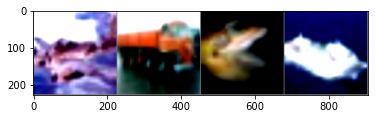

Airplane Truck  Frog  Ship


In [7]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [8]:
AlexNet_Model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to C:\Users\ifisa/.cache\torch\hub\v0.6.0.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\ifisa/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth


In [9]:
AlexNet_Model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [10]:
import torch.nn as nn
AlexNet_Model.classifier[1] = nn.Linear(9216,4096)
AlexNet_Model.classifier[4] = nn.Linear(4096,1024)
AlexNet_Model.classifier[6] = nn.Linear(1024,10)

In [11]:
AlexNet_Model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [16]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(AlexNet_Model.parameters(), lr=0.001, momentum=0.9)

In [17]:
import time

In [ ]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    start_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = AlexNet_Model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        #Time
        end_time = time.time()
        time_taken = end_time - start_time

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            print('Time:',time_taken)
            running_loss = 0.0

print('Finished Training of AlexNet: Epoch 1')

[1,  2000] loss: 1.216
Time: 414.68788957595825
[1,  4000] loss: 0.896
Time: 839.5067777633667


In [52]:
# Raw Dataset Directory
data_dir = pathlib.Path("C://Users//ifisa//Documents//capstone-liu-2022//artificial-tensor/flower_photos")
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)
# classnames in the dataset specified
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt" ])
print(CLASS_NAMES)
# print length of class names
output_class_units = len(CLASS_NAMES)
print(output_class_units)

3670
['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']
5


In [53]:
model = tf.keras.models.Sequential([
    # 1st conv
  tf.keras.layers.Conv2D(96, (11,11),strides=(4,4), activation='relu', input_shape=(227, 227, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, strides=(2,2)),
    # 2nd conv
  tf.keras.layers.Conv2D(256, (11,11),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
     # 3rd conv
  tf.keras.layers.Conv2D(384, (3,3),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
    # 4th conv
  tf.keras.layers.Conv2D(384, (3,3),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
    # 5th Conv
  tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, strides=(2, 2)),
  # To Flatten layer
  tf.keras.layers.Flatten(),
  # To FC layer 1
  tf.keras.layers.Dense(4096, activation='relu'),
    # add dropout 0.5 ==> tf.keras.layers.Dropout(0.5),
  #To FC layer 2
  tf.keras.layers.Dense(4096, activation='relu'),
    # add dropout 0.5 ==> tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(output_class_units, activation='softmax')
])

In [70]:
# Shape of inputs to NN Model
BATCH_SIZE = 32             # Can be of size 2^n, but not restricted to. for the better utilization of memory
IMG_HEIGHT = 227            # input Shape required by the model
IMG_WIDTH = 227             # input Shape required by the model
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

# Rescalingthe pixel values from 0~255 to 0~1 For RGB Channels of the image.
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
# training_data for model training
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH), #Resizing the raw dataset
                                                     classes = list(CLASS_NAMES))

Found 3670 images belonging to 5 classes.


In [76]:
train_data_gen.labels.shape

(3670,)

In [55]:
# Specifying the optimizer, Loss function for optimization & Metrics to be displayed
model.compile(optimizer='sgd', loss="categorical_crossentropy", metrics=['accuracy'])

# Summarizing the model architecture and printing it out
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_10 (Batc (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 27, 27, 256)       2973952   
_________________________________________________________________
batch_normalization_11 (Batc (None, 27, 27, 256)       1024      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 27, 27, 384)       885120    
_________________________________________________________________
batch_normalization_12 (Batc (None, 27, 27, 384)      

In [56]:
# callbacks at training
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if (logs.get("accuracy")==1.00 and logs.get("loss")<0.03):
            print("\nReached 100% accuracy so stopping training")
            self.model.stop_training =True
callbacks = myCallback()

# TensorBoard.dev Visuals
log_dir="logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [69]:
print(tf.keras.backend.eval(train_data_gen[4]))

TypeError: '>=' not supported between instances of 'tuple' and 'int'

In [33]:
## plot embeddings before starting
generate_embedding()

AttributeError: 'bool' object has no attribute 'reshape'

In [ ]:
# Training the Model
history = model.fit(
      train_data_gen,
      steps_per_epoch=STEPS_PER_EPOCH,
      epochs=1,
      callbacks=[tensorboard_callback,callbacks])

# Saving the model
model.save('AlexNet_saved_model/')

In [ ]:
## plot embeddings after 1 epoch

In [ ]:
# Training the Model
history = model.fit(
      y_train,
      steps_per_epoch=STEPS_PER_EPOCH,
      epochs=1,
      callbacks=[tensorboard_callback,callbacks])

# Saving the model
model.save('AlexNet_saved_model/')

In [ ]:
## plot embeddings after 2 epochs